# Analyzing First Street Foundation's flood insurance data and ZCTA characteristics<br>
Story published https://www.npr.org/2021/02/22/966428165/a-looming-disaster-new-data-reveal-where-flood-damage-is-an-existential-threat<br>

First Street Foundation shared with NPR data about the cost of structural damage that are project to do to flood-prone properties on the zip code level.<br>

Their national report with methodology and data overview published on Feb. 22nd.https://firststreet.org/flood-lab/published-research/highlights-from-the-cost-of-climate-americas-growing-flood-risk/<br>

Here's where they host the datasets https://registry.opendata.aws/fsf-flood-risk/ <br>

Structural damage of homes is measured by average annualized loss, or AAL. Here is their paper detailing how they assessed AAL https://www.mdpi.com/2225-1154/8/10/116/htm.<br>

Flood prone properties are properties that have 1/100 FF, which is FSF’s assessment of risk for 100 year floods. <br>

The flood prone properties at 60% of the zctas currently are not paying as enough premium to cover their AAL in aggregate, and since they are the accepted insurance pool of the national flood insurance program, we want to know what’s different about the communities where the properties are getting the better and worse deals. A fair deal is when AAL equals the yearly flood insurance premium; a good deal is when AAL>flood insurance premium, and a bad deal is when AAL< flood insurance premium.<br>

In [1]:
import pandas as pd
import csv
import re
import scipy
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import wilcoxon
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import mapclassify
import scikit_posthocs as sp
import math
import statsmodels.api as sm
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.html.use_mathjax = False

# Putting together data

_Zipcode tabulation area to county crosswalk data<br>_
Source: HUD https://www.huduser.gov/portal/datasets/usps_crosswalk.html<br>
Explanation from the Census<br>
https://www2.census.gov/geo/pdfs/maps-data/data/rel/explanation_zcta_county_rel_10.pdf?#

In [2]:
cwd = os.getcwd()

In [3]:
# using total ratio because it yields the most matches.
zctatocty = pd.read_excel(cwd + '/ZIP_COUNTY_122020.xlsx')
zcta2cty = zctatocty[zctatocty.TOT_RATIO >= .7][['ZIP','COUNTY','TOT_RATIO']].copy()
zcta2cty = zcta2cty.rename(columns={'ZIP':'zipcode'})

_Percentage of white nonhispanic residents in each zcta<br>_
Source: Census bureau - B03002 by zcta<br>
https://data.census.gov/cedsci/table?text=B03002&g=0100000US.860000&tid=ACSDT5Y2019.B03002&hidePreview=false <br>

In [4]:
racezip = pd.read_csv(cwd + '/ACSDT5Y2019_B03002_data_with_overlays_2021-01-24T140653.csv', low_memory = False)
# dropping the definition column
racezip = racezip.drop(0)
racezip = racezip.rename(columns = {'B03002_001E':'total_pop','B03002_003E':'white_nonhisp','B03002_012E':'latino'})
# getting rid of asterisks to change data into floats
for col in list(racezip.columns[2:]):
    racezip[col] = racezip[col].replace('*****',np.nan)
    racezip[col] = racezip[col].astype(float)
# combining black hispanic and black non-hispanic
racezip['black'] = racezip.B03002_014E + racezip.B03002_004E
# this is the variable we'll be working with in the analysis
racezip['white_pct'] = racezip.white_nonhisp/racezip.total_pop

In [5]:
# checking to see if the numbers adds up nationwide. Seems in the ball park.
print('Percent of white non-hispanic residents in the US')
print(racezip.white_nonhisp.sum()/racezip.total_pop.sum()*100)
print ('Percent of Black residents in the US')
print(racezip.black.sum()/racezip.total_pop.sum()*100)

Percent of white non-hispanic residents in the US
60.09909543802166
Percent of Black residents in the US
12.688745840106122


In [6]:
# this is a slice of the previous database. We'll use it to join with the others.
racezipw = racezip[['GEO_ID','NAME','total_pop','white_nonhisp','white_pct','black','latino']].copy()
racezipw.head()
racezipw['zipcode']  = [x.split(' ')[-1] for x in racezipw.NAME]
racezipw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33120 entries, 1 to 33120
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GEO_ID         33120 non-null  object 
 1   NAME           33120 non-null  object 
 2   total_pop      33120 non-null  float64
 3   white_nonhisp  33120 non-null  float64
 4   white_pct      32776 non-null  float64
 5   black          33120 non-null  float64
 6   latino         33120 non-null  float64
 7   zipcode        33120 non-null  object 
dtypes: float64(5), object(3)
memory usage: 2.3+ MB


_Median household income in the past 12 months by zcta<br>_
Source: Census bureau <br>
https://data.census.gov/cedsci/table?text=B19013&g=0100000US.860000&tid=ACSDT5Y2019.B19013&hidePreview=false<br>

In [7]:
incomeraw = pd.read_csv(cwd + '/ACSDT5Y2019.B19013_data_with_overlays_2021-01-24T201521.csv')
incomeraw = incomeraw.drop(0)
incomebyzip  = incomeraw[['GEO_ID','NAME','B19013_001E']].copy()
incomebyzip = incomebyzip.rename(columns = {'B19013_001E':'median_household_income'})
incomebyzip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33120 entries, 1 to 33120
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   GEO_ID                   33120 non-null  object
 1   NAME                     33120 non-null  object
 2   median_household_income  33120 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [8]:
censuszip = pd.merge(incomebyzip,racezipw, on = 'GEO_ID', how = 'outer')
censuszip[censuszip.NAME_x != censuszip.NAME_y]
censuszip = censuszip.drop(['NAME_x','NAME_y'], axis = 1)
censuszip.zipcode = censuszip.zipcode.astype(int)
censuszip.info()
# seems that the race and income data all matched up for the zipcodes.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33120 entries, 0 to 33119
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GEO_ID                   33120 non-null  object 
 1   median_household_income  33120 non-null  object 
 2   total_pop                33120 non-null  float64
 3   white_nonhisp            33120 non-null  float64
 4   white_pct                32776 non-null  float64
 5   black                    33120 non-null  float64
 6   latino                   33120 non-null  float64
 7   zipcode                  33120 non-null  int32  
dtypes: float64(5), int32(1), object(2)
memory usage: 2.1+ MB


_First Street Foundation data on average annualized loss_

In [9]:
fsfraw = pd.read_csv(cwd + '/AAL data - zcta data 021521.csv')
fsfraw.columns = fsfraw.columns.str.strip()
fsfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30912 entries, 0 to 30911
Data columns (total 42 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   state fips                                                      30912 non-null  int64  
 1   name                                                            30912 non-null  int64  
 2   total residential (1-4) properties                              30912 non-null  int64  
 3   residential properties with 1/100 FSF risk                      28673 non-null  float64
 4   number of properties with structural damage, 2020               30912 non-null  int64  
 5   properties with structural damage, 2020 (%)                     30912 non-null  float64
 6   number of properties with structural damage, 2050               26533 non-null  float64
 7   properties with structural damage, 2050 (%)      

In [10]:
fsf = fsfraw[['name',
              'difference of avg NFIP premium vs capped AAL 2020 (%)',
              'difference of avg NFIP premium vs capped AAL 2050 (%)',
              'total 2020 capped AAL ($)',
              'total 2050 capped AAL ($)',
              'total structural AVM - res. prop. with risk ($)',
              'loss of structure AVM, 2020, (properties with subst. risk) (%)',
              'loss of structure AVM, 2050, (properties with subst. risk) (%)',
              'total residential (1-4) properties',
              'number of properties with structural damage, 2020',
              'number of properties with structural damage, 2050']].copy()
fsf.columns = ['zipcode',
               'avr_AAL_NFIP_20',
               'avr_AAL_NFIP_50',
               'total_aal_20',
               'total_aal_50',
               'total_structural_avm_100yrs',
               'AAL_AVM_risk_20_pct',
               'AAL_AVM_risk_50_pct',
               'total_property_cnt',
               'properties_with_aal_20_cnt',
               'properties_with_aal_50_cnt']

In [11]:
fsf['pct_homes_with_risk_20'] = fsf.properties_with_aal_20_cnt/fsf.total_property_cnt*100
fsf['pct_homes_with_risk_50'] = fsf.properties_with_aal_50_cnt/fsf.total_property_cnt*100

_Merging data_

In [12]:
dflist = [censuszip,fsf,zcta2cty]
alldf = reduce(lambda left,right: pd.merge(left, right,left_on = 'zipcode', right_on='zipcode', how = 'outer'), dflist)
alldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39547 entries, 0 to 39546
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GEO_ID                       33120 non-null  object 
 1   median_household_income      33120 non-null  object 
 2   total_pop                    33120 non-null  float64
 3   white_nonhisp                33120 non-null  float64
 4   white_pct                    32776 non-null  float64
 5   black                        33120 non-null  float64
 6   latino                       33120 non-null  float64
 7   zipcode                      39547 non-null  int64  
 8   avr_AAL_NFIP_20              26471 non-null  float64
 9   avr_AAL_NFIP_50              26468 non-null  float64
 10  total_aal_20                 30912 non-null  float64
 11  total_aal_50                 26468 non-null  float64
 12  total_structural_avm_100yrs  26471 non-null  float64
 13  AAL_AVM_risk_20_

In [13]:
# cleaning up median household income data
alldf.median_household_income = alldf.median_household_income.str.replace('-','')
alldf.median_household_income = alldf.median_household_income.replace(r'^\s*$',np.nan, regex = True)
alldf.median_household_income = alldf.median_household_income.str.replace(',','')
alldf.median_household_income = alldf.median_household_income.str.replace('+','')
alldf.median_household_income = alldf.median_household_income.astype(float)

In [14]:
alldf['state_parsed'] = round(alldf.zipcode/1000)

In [15]:
def cleanlist(li):
    return ([x for x in li if pd.isna(x) == False])

In [16]:
# making county-wide array for inter-county comparison
allarrays = alldf.groupby('COUNTY').agg(lambda white_pct:white_pct.tolist())

In [17]:
allarrays['white_pct_cleaned'] = [cleanlist(x) for x in allarrays.white_pct]
allarrays['income_cleaned']  = [cleanlist(x) for x in allarrays.median_household_income]
allarrays['aal_nfip_20_cleaned'] = [cleanlist(x) for x in allarrays.avr_AAL_NFIP_20]
allarrays['aal_nfip_50_cleaned'] = [cleanlist(x) for x in allarrays.avr_AAL_NFIP_50]
allarrays['properties_with_aal_20_cnt_cleaned'] = [cleanlist(x) for x in allarrays.properties_with_aal_20_cnt]
allarrays = allarrays.reset_index()

In [18]:
countyarray = allarrays[['COUNTY', 'white_pct_cleaned','income_cleaned','aal_nfip_20_cleaned','aal_nfip_50_cleaned','properties_with_aal_20_cnt_cleaned']].copy()
countyarray.columns = ['COUNTY','white_pct_array','income_array','aal_nfip_20_array','aal_nfip_50_array','properties_with_aal_20_cnt_array']

In [19]:
alldf1 = pd.merge(alldf, countyarray, on = 'COUNTY', how = 'left')

In [20]:
# returns quantiles of a number in an array
def get_score(y,x):
    if type(y) == list:
        return (stats.percentileofscore(y,x))
    else:
        return (np.nan)

In [21]:
# binning all zipcodes by how their NFIP deals rank nationally
nfiplimits20 = mapclassify.Quantiles(alldf1[(pd.isna(alldf1.avr_AAL_NFIP_20) == False)].avr_AAL_NFIP_20, k=4).bins
nfiplimits50 = mapclassify.Quantiles(alldf1[(pd.isna(alldf1.avr_AAL_NFIP_50) == False)].avr_AAL_NFIP_50, k=4).bins

In [22]:
# functions for sorting zctas into quartiles nationally for both 2020 and 2050
def aal_nfip_qt_20(num):
    if num <= nfiplimits20[0]:
        return 1
    else:
        if (num > nfiplimits20[0]) & (num <= nfiplimits20[1]):
            return (2)
        else:
            if (num > nfiplimits20[1]) & (num <= nfiplimits20[2]):
                return(3)
            else:
                if(num > nfiplimits20[2]) & (num <= nfiplimits20[3]):
                    return(4)
                else:
                    return(np.nan)

def aal_nfip_qt_50(num):
    if num <= nfiplimits50[0]:
        return(1)
    else:
        if (num > nfiplimits50[0]) & (num <= nfiplimits50[1]):
            return (2)
        else:
            if (num > nfiplimits50[1]) & (num <= nfiplimits50[2]):
                return(3)
            else:
                if(num > nfiplimits50[2]) & (num <= nfiplimits50[3]):
                    return(4)
                else:
                    return(np.nan)

In [23]:
alldf1['race_quantile'] = [get_score(y,x) for (y,x) in zip(alldf1.white_pct_array, alldf1.white_pct)]
alldf1['income_quantile'] = [get_score(y,x) for (y,x) in zip(alldf1.income_array, alldf1.median_household_income)]
alldf1['aal_nfip_20_quantile'] = [get_score(y,x) for (y,x) in zip(alldf1.aal_nfip_20_array, alldf1.avr_AAL_NFIP_20)]
alldf1['aal_nfip_50_quantile'] =  [get_score(y,x) for (y,x) in zip(alldf1.aal_nfip_50_array, alldf1.avr_AAL_NFIP_50)]
alldf1['properties_with_aal_20_cnt_quantile'] = [get_score(y,x) for (y,x) in zip(alldf1.properties_with_aal_20_cnt_array, alldf1.properties_with_aal_20_cnt)]

In [24]:
# function for sorting zctas according to their NFIP deals county wide.
def local_nfip_qt(num):
    if num <=25:
        return(1)
    if (num > 25) & (num <=50):
        return(2)
    if (num>50) & (num <=75):
        return(3)
    if (num > 75):
        return(4)

In [25]:
alldf1['avr_AAL_NFIP_qt_20'] = [aal_nfip_qt_20(x) for x in alldf1.avr_AAL_NFIP_20]
alldf1['avr_AAL_NFIP_qt_50'] = [aal_nfip_qt_50(x) for x in alldf1.avr_AAL_NFIP_50]
alldf1['local_avr_AAL_NFIP_20_qt'] = [local_nfip_qt(x) for x in alldf1.aal_nfip_20_quantile]
alldf1['local_avr_AAL_NFIP_50_qt'] = [local_nfip_qt(x) for x in alldf1.aal_nfip_50_quantile]
alldf1['local_properties_with_aal_20_cnt_qt'] = [local_nfip_qt(x) for x in alldf1.properties_with_aal_20_cnt_quantile]

In [26]:
# measuring the length of arrays b/c we need to exclude zctas that are the only zcta in the county from county-wide comparison
alldf1['income_array_len'] = [len(x) if type(x) == list else np.nan for x in alldf1.income_array]
alldf1['race_array_len'] = [len(x) if type(x) == list else np.nan for x in alldf1.white_pct_array]
alldf1['avr_AAL_NFIP_20_array_len'] = [len(x) if type(x) == list else np.nan for x in alldf1.aal_nfip_20_array]
alldf1['avr_AAL_NFIP_50_array_len'] = [len(x) if type(x) == list else np.nan for x in alldf1.aal_nfip_50_array]
alldf1['properties_with_aal_20_cnt_array_len'] = [len(x) if type(x) == list else np.nan for x in alldf1.properties_with_aal_20_cnt_array]

In [27]:
# sorting zctas into quartiles based on the number of flood-prone homes that they have.
sizeqtbins_20 = mapclassify.Quantiles(alldf1[alldf1.properties_with_aal_20_cnt>0].properties_with_aal_20_cnt, k = 4).bins
sizeqtbins_50 = mapclassify.Quantiles(alldf1[alldf1.properties_with_aal_50_cnt>0].properties_with_aal_50_cnt, k = 4).bins

def zcta_cnt_20_qt(num):
    if (num <= sizeqtbins_20[0]) & (num>0):
        return(1)
    if (num > sizeqtbins_20[0] ) & (num <= sizeqtbins_20[1]):
        return(2)
    if (num > sizeqtbins_20[1]) & (num <= sizeqtbins_20[2]):
        return(3)
    if (num > sizeqtbins_20[2]):
        return(4)
    
def zcta_cnt_50_qt(num):
    if (num <= sizeqtbins_50[0]) & (num>0):
        return(1)
    if (num > sizeqtbins_50[0] ) & (num <= sizeqtbins_50[1]):
        return(2)
    if (num > sizeqtbins_50[1]) & (num <= sizeqtbins_50[2]):
        return(3)
    if (num > sizeqtbins_50[2]):
        return(4)

In [28]:
alldf1['cnt_home_at_risk_qt_20'] = [zcta_cnt_20_qt(x) if pd.isna(x)== False else np.nan for x in alldf1.properties_with_aal_20_cnt]
alldf1['cnt_home_at_risk_qt_50'] = [zcta_cnt_50_qt(x) if pd.isna(x)== False else np.nan for x in alldf1.properties_with_aal_50_cnt]
alldf1['national_income_quantile'] = [stats.percentileofscore(alldf1.median_household_income,x)/100 if x> float(0) else np.nan for x in alldf1.median_household_income]
alldf1['avr_aal_nfip_20_simple'] = [x+1 if pd.isna(x)== False else np.nan for x in alldf1.avr_AAL_NFIP_20]
alldf1['avr_aal_nfip_50_simple'] = [x+1 if pd.isna(x)== False else np.nan for x in alldf1.avr_AAL_NFIP_50]

In [29]:
alldf1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39547 entries, 0 to 39546
Data columns (total 48 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   GEO_ID                                33120 non-null  object 
 1   median_household_income               30821 non-null  float64
 2   total_pop                             33120 non-null  float64
 3   white_nonhisp                         33120 non-null  float64
 4   white_pct                             32776 non-null  float64
 5   black                                 33120 non-null  float64
 6   latino                                33120 non-null  float64
 7   zipcode                               39547 non-null  int64  
 8   avr_AAL_NFIP_20                       26471 non-null  float64
 9   avr_AAL_NFIP_50                       26468 non-null  float64
 10  total_aal_20                          30912 non-null  float64
 11  total_aal_50   

# Data Analysis
## National Look
### Race

In [30]:
# setting the outliers as 2.5 standard deviation from the mean. Since the range of aal/nfip doesn't go below 0, only the maximum cutoff is meaningful.
def outliers_cleaned(series):
    if type(series) == list:
        series = pd.Series(series)
    stdrange = np.std(series)*2.5
    median = series.median()
    cutoffmax = median+stdrange
    cutoffmin = median-stdrange
    return[cutoffmin,cutoffmax]

In [31]:
outliers_cleaned(alldf1.avr_aal_nfip_20_simple)

[-21.586949749252216, 24.500949749252218]

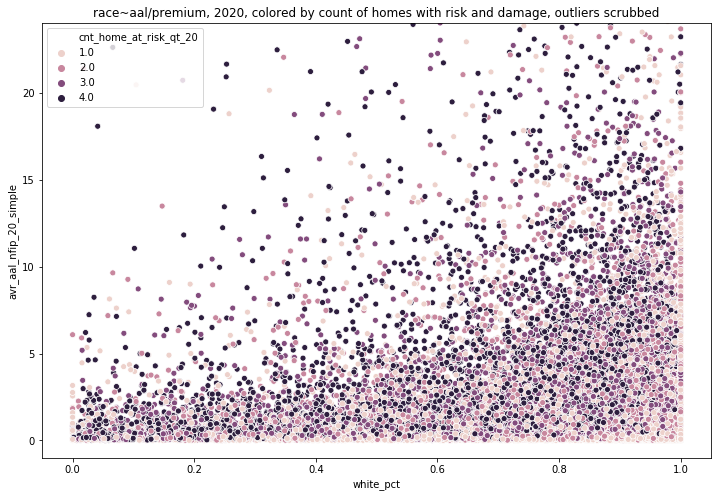

In [32]:
# plotting original data, race~aal/premium
plt.figure(figsize=(12, 8))
sns.scatterplot(alldf1.white_pct, alldf1.avr_aal_nfip_20_simple, hue =alldf1.cnt_home_at_risk_qt_20)
plt.ylim((-1,24))
plt.title('race~aal/premium, 2020, colored by count of homes with risk and damage, outliers scrubbed');

In [33]:
# Trying a logarithmic transformation.
alldf1['x_transformed_20'] = [np.log10(x) if x!=0 else np.nan for x in alldf1.avr_aal_nfip_20_simple]
alldf1['x_transformed_50'] = [np.log10(x) if x!=0 else np.nan for x in alldf1.avr_aal_nfip_50_simple]

In [34]:
x_transformed_20_outliers = outliers_cleaned(alldf1.x_transformed_20)
x_transformed_50_outliers = outliers_cleaned(alldf1.x_transformed_50)

In [35]:
alldf1['x_transformed_20_outlier'] = [0 if ((x >= x_transformed_20_outliers[0]) & (x<= x_transformed_20_outliers[1])) else 1 for x in alldf1.x_transformed_20]
alldf1['x_transformed_50_outlier'] = [0 if ((x >= x_transformed_50_outliers[0]) & (x<= x_transformed_50_outliers[1])) else 1 for x in alldf1.x_transformed_50]

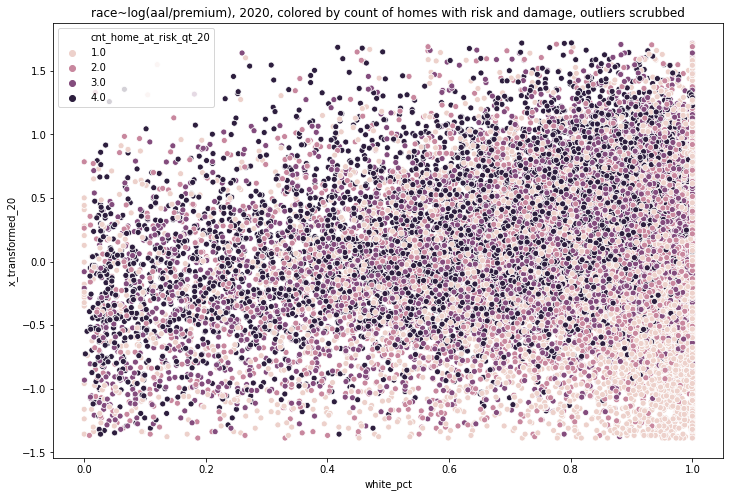

In [36]:
# race ~ log(aal/premium), colorcoding for count of flood prone homes, 2020
plt.figure(figsize=(12, 8))
sns.scatterplot(alldf1[alldf1.x_transformed_20_outlier ==0].white_pct, alldf1[alldf1.x_transformed_20_outlier ==0].x_transformed_20, hue =alldf1.cnt_home_at_risk_qt_20)
plt.title('race~log(aal/premium), 2020, colored by count of homes with risk and damage, outliers scrubbed');

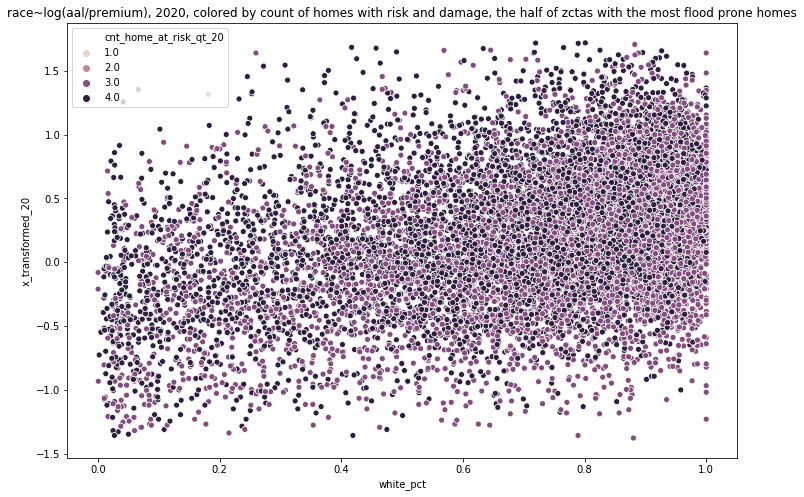

In [37]:
# race ~ aal/premium, colorcoding for count of flood prone homes, 2020
plt.figure(figsize=(12, 8))
sns.scatterplot(alldf1[(alldf1.x_transformed_20_outlier ==0) & (alldf1.cnt_home_at_risk_qt_20>2)].white_pct, alldf1[ (alldf1.x_transformed_20_outlier ==0) & (alldf1.cnt_home_at_risk_qt_20>2)].x_transformed_20, hue =alldf1.cnt_home_at_risk_qt_20)
plt.title('race~log(aal/premium), 2020, colored by count of homes with risk and damage, the half of zctas with the most flood prone homes');

In [38]:
# white_pct~x_transformed_20, for cnt>0 , weighted by cnt, outliers scrubbed
whitepct20X = alldf1[(pd.isna(alldf1.white_pct) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.properties_with_aal_20_cnt>0) & (alldf1.x_transformed_20_outlier == 0)].white_pct
whitepct20X = sm.add_constant(whitepct20X)
mod_wls = sm.WLS( alldf1[(pd.isna(alldf1.white_pct) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.properties_with_aal_20_cnt>0)& (alldf1.x_transformed_20_outlier == 0)].x_transformed_20,
                 whitepct20X,
                 weights=alldf1[(pd.isna(alldf1.white_pct) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.properties_with_aal_20_cnt>0)& (alldf1.x_transformed_20_outlier == 0)].properties_with_aal_20_cnt)
whitepct20fit = mod_wls.fit()
whitepct20coef = whitepct20fit.params[1]
print ('white_pct~log(aal/premium), weighted by count of flood prone homes, outliers scrubbed')
print(whitepct20fit.summary())

white_pct~log(aal/premium), weighted by count of flood prone homes, outliers scrubbed
                            WLS Regression Results                            
Dep. Variable:       x_transformed_20   R-squared:                       0.110
Model:                            WLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     3166.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:10:50   Log-Likelihood:                -39247.
No. Observations:               25727   AIC:                         7.850e+04
Df Residuals:                   25725   BIC:                         7.851e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [39]:
# white_pct~x_transformed_20, for cnt>0 , weighted by cnt, outliers scrubbed
whitepct20X = alldf1[(pd.isna(alldf1.white_pct) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.cnt_home_at_risk_qt_20>2) & (alldf1.x_transformed_20_outlier == 0)].white_pct
whitepct20X = sm.add_constant(whitepct20X)
mod_wls = sm.WLS( alldf1[(pd.isna(alldf1.white_pct) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.cnt_home_at_risk_qt_20>2)& (alldf1.x_transformed_20_outlier == 0)].x_transformed_20,
                 whitepct20X,
                 weights=alldf1[(pd.isna(alldf1.white_pct) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.cnt_home_at_risk_qt_20>2)& (alldf1.x_transformed_20_outlier == 0)].properties_with_aal_20_cnt)
whitepct20fit = mod_wls.fit()
whitepct20coef = whitepct20fit.params[1]
print ('white_pct~log(aal/premium) for the half of zctas with most flood prone homes, weighted by count of flood prone homes, outliers scrubbed')
print(whitepct20fit.summary())

white_pct~log(aal/premium) for the half of zctas with most flood prone homes, weighted by count of flood prone homes, outliers scrubbed
                            WLS Regression Results                            
Dep. Variable:       x_transformed_20   R-squared:                       0.118
Model:                            WLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     1743.
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:10:51   Log-Likelihood:                -14068.
No. Observations:               13086   AIC:                         2.814e+04
Df Residuals:                   13084   BIC:                         2.815e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.

The R-squared too low to report. There are probably other variables at play that we don't have data for here, like previous evaluations of flood risk.<br>

Binning the data to see if the quartiles of zctas getting different deals differ from each other in terms of race. The higher the quartile, the better the deal.<br>

Statistical tests used in this analysis - <br>
- Levene test, to see if the quartiles have equal variance and therefore satisfy one of the assumptions for an ANOVA test. The null hypothesis for the test is that the distributions have equal variance. Documentation here - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
- All the distributions rejected the null hypothesis in Levene test, so we used the non-parametric equivalent of ANOVA -  Kruskal-Wallis H-test. Documentation here - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html<br>
- When the p value of Kruskal-Wallis test comes back below <.05, suggesting that not all the distributions are the same, we perform a Dunn's post hoc test, which gives us pair-wise comparison results. Bonferroni's adjustment was used, because it adjusts for family wise errors in a conservative manner. Documentation about the test here - https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn/.

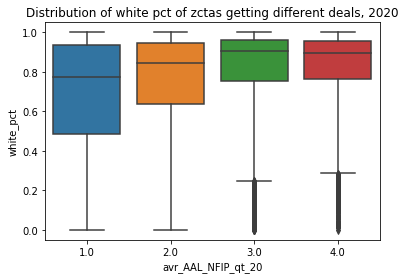

In [40]:
# visual cues
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'white_pct', data= alldf1, whis = 2.5)
plt.title('Distribution of white pct of zctas getting different deals, 2020');

Comparing the white pct in zctas getting different deals nationwide, by count of flood-prone homes, 2020


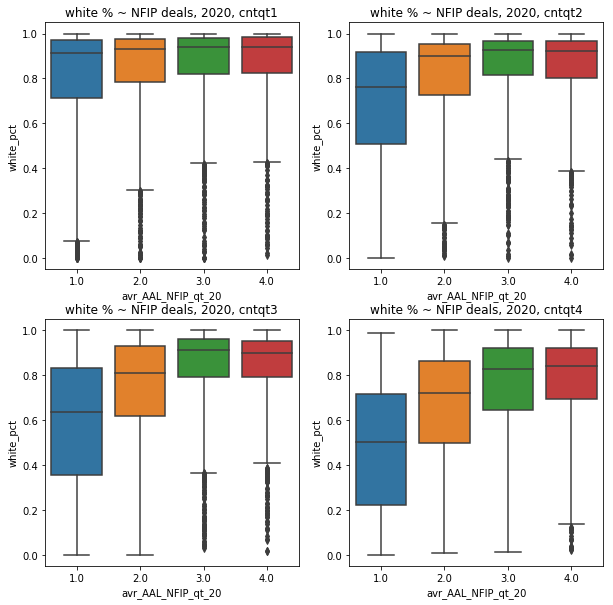

In [41]:
# visual cues by quartile of count of properties at risk
print ('Comparing the white pct in zctas getting different deals nationwide, by count of flood-prone homes, 2020')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'white_pct', data= alldf1[alldf1.cnt_home_at_risk_qt_20==1],whis = 2.5)
plt.title('white % ~ NFIP deals, 2020, cntqt1')

ax = fig.add_subplot(222)
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'white_pct', data= alldf1[alldf1.cnt_home_at_risk_qt_20==2],whis = 2.5)
plt.title('white % ~ NFIP deals, 2020, cntqt2')

ax = fig.add_subplot(223)
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'white_pct', data= alldf1[alldf1.cnt_home_at_risk_qt_20==3],whis = 2.5)
plt.title('white % ~ NFIP deals, 2020, cntqt3')

ax = fig.add_subplot(224)
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'white_pct', data= alldf1[alldf1.cnt_home_at_risk_qt_20==4],whis = 2.5)
plt.title('white % ~ NFIP deals, 2020, cntqt4');

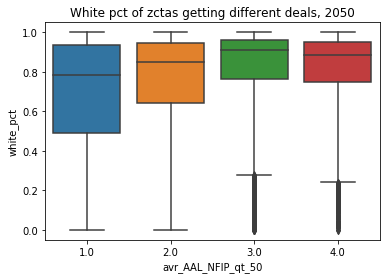

In [42]:
# visual cues
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'white_pct', data= alldf1,whis = 2.5)
plt.title('White pct of zctas getting different deals, 2050');

Comparing the percentage of white residents in zctas getting different deals nationwide, by count of flood-prone homes, 2050


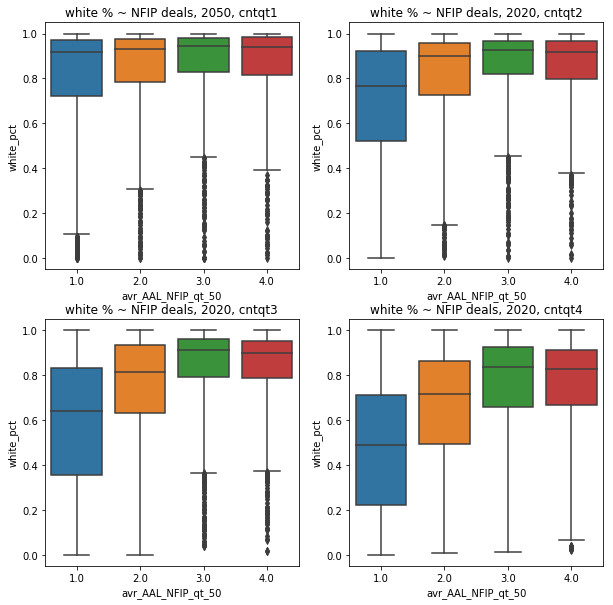

In [43]:
print ('Comparing the percentage of white residents in zctas getting different deals nationwide, by count of flood-prone homes, 2050')
# visual cues by quartile of count of properties at risk
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'white_pct', data= alldf1[alldf1.cnt_home_at_risk_qt_50==1],whis = float(2.5))
plt.title('white % ~ NFIP deals, 2050, cntqt1')

ax = fig.add_subplot(222)
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'white_pct', data= alldf1[alldf1.cnt_home_at_risk_qt_50==2],whis = float(2.5))
plt.title('white % ~ NFIP deals, 2020, cntqt2')

ax = fig.add_subplot(223)
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'white_pct', data= alldf1[alldf1.cnt_home_at_risk_qt_50==3],whis = float(2.5))
plt.title('white % ~ NFIP deals, 2020, cntqt3')

ax = fig.add_subplot(224)
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'white_pct', data= alldf1[alldf1.cnt_home_at_risk_qt_50==4],whis = float(2.5))
plt.title('white % ~ NFIP deals, 2020, cntqt4');

In [44]:
# Grouping the nationwide data to perform statistical tests
avr_aal_nfip_race_20 = [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.white_pct) == False)].white_pct,
                        alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.white_pct) == False)].white_pct,
                        alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.white_pct) == False)].white_pct,
                        alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.white_pct) == False)].white_pct]

In [45]:
print ('Descriptive stats for distributions of white pct for zctas with different deals, 2020')
[x.describe() for x in avr_aal_nfip_race_20]

Descriptive stats for distributions of white pct for zctas with different deals, 2020


[count    6611.000000
 mean        0.682245
 std         0.292314
 min         0.000000
 25%         0.484453
 50%         0.776066
 75%         0.935031
 max         1.000000
 Name: white_pct, dtype: float64,
 count    6609.000000
 mean        0.760817
 std         0.236922
 min         0.000000
 25%         0.638850
 50%         0.845885
 75%         0.947037
 max         1.000000
 Name: white_pct, dtype: float64,
 count    6609.000000
 mean        0.821887
 std         0.204291
 min         0.000000
 25%         0.756123
 50%         0.904666
 75%         0.960000
 max         1.000000
 Name: white_pct, dtype: float64,
 count    6603.000000
 mean        0.829740
 std         0.182586
 min         0.000000
 25%         0.764274
 50%         0.895501
 75%         0.955908
 max         1.000000
 Name: white_pct, dtype: float64]

In [46]:
print('Can we reject the null hypothesis that the distributions have equal variance?')
stats.levene(avr_aal_nfip_race_20[0],avr_aal_nfip_race_20[1],avr_aal_nfip_race_20[2],avr_aal_nfip_race_20[3])[1]<.05
# Yes. Use non-parametric test.

Can we reject the null hypothesis that the distributions have equal variance?


True

In [47]:
print('Are the distributions not all the same?')
stats.kruskal(avr_aal_nfip_race_20[0],avr_aal_nfip_race_20[1],avr_aal_nfip_race_20[2],avr_aal_nfip_race_20[3])[1]<.05
# They are.

Are the distributions not all the same?


True

In [48]:
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_20, p_adjust = 'bonferroni')<.05
# seems that the third and fourth quartiles aren't significantly different from each other in terms of white percentage, but the rest are.

In pair-wise comparison between the four quartiles, they different from each other?


,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


In [49]:
# accounting for number of flood risk homes in the zipcode
print ('Comparing the distribution of white pct in the quartile of zctas with the smallest number of flood prone homes, 2020')
avr_aal_nfip_race_20_qt1= [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.white_pct) == False) & (alldf1.cnt_home_at_risk_qt_20 == 1)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 1)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 1)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 1)].white_pct]

print([x.describe() for x in avr_aal_nfip_race_20_qt1])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_race_20_qt1[0],avr_aal_nfip_race_20_qt1[1],avr_aal_nfip_race_20_qt1[2],avr_aal_nfip_race_20_qt1[3])[1]<.05)
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_20_qt1, p_adjust = 'bonferroni')<.05
# seems that for the quartile of zctas with the smallest number of flood-prone homes, the second and third quartile as well as the third and fourth quartile in terms of deals aren't significantly different from each other in terms of white percentage. The quartile getting the worst deal is different - less white- from all the rest.

Comparing the distribution of white pct in the quartile of zctas with the smallest number of flood prone homes, 2020
[count    2881.000000
mean        0.799840
std         0.246819
min         0.000000
25%         0.713328
50%         0.914634
75%         0.969407
max         1.000000
Name: white_pct, dtype: float64, count    1534.000000
mean        0.839904
std         0.209127
min         0.000000
25%         0.783333
50%         0.932590
75%         0.976665
max         1.000000
Name: white_pct, dtype: float64, count    1246.000000
mean        0.856048
std         0.197884
min         0.000000
25%         0.818864
50%         0.941430
75%         0.978399
max         1.000000
Name: white_pct, dtype: float64, count    1386.000000
mean        0.866811
std         0.181361
min         0.015436
25%         0.824662
50%         0.940460
75%         0.983223
max         1.000000
Name: white_pct, dtype: float64]
Are the distributions not all the same?
True
In pair-wise comparison between t

,1,2,3,4
1,False,True,True,True
2,True,False,False,True
3,True,False,False,False
4,True,True,False,False


In [50]:
print ('Comparing the distribution of white pct in the quartile of zctas with the second smallest number of flood prone homes, 2020')
avr_aal_nfip_race_20_qt2= [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.white_pct) == False) & (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct]

print([x.describe() for x in avr_aal_nfip_race_20_qt2])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_race_20_qt2[0],avr_aal_nfip_race_20_qt2[1],avr_aal_nfip_race_20_qt2[2],avr_aal_nfip_race_20_qt2[3])[1]<.05)
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_20_qt2, p_adjust = 'bonferroni')<.05
# seems that the two quartiles of zctas getting the best deals aren't significantly different from one another. The rest are.

Comparing the distribution of white pct in the quartile of zctas with the second smallest number of flood prone homes, 2020
[count    1399.000000
mean        0.683467
std         0.271483
min         0.001048
25%         0.505979
50%         0.761603
75%         0.918958
max         1.000000
Name: white_pct, dtype: float64, count    1713.000000
mean        0.810182
std         0.210898
min         0.010038
25%         0.726666
50%         0.900000
75%         0.955520
max         1.000000
Name: white_pct, dtype: float64, count    1720.000000
mean        0.856673
std         0.177218
min         0.000000
25%         0.816402
50%         0.926045
75%         0.967965
max         1.000000
Name: white_pct, dtype: float64, count    1381.000000
mean        0.855674
std         0.170462
min         0.000000
25%         0.801075
50%         0.920471
75%         0.966762
max         1.000000
Name: white_pct, dtype: float64]
Are the distributions not all the same?
True
In pair-wise comparison be

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


In [51]:
print ('Comparing the distribution of white pct in the quartile of zctas with the second largest number of flood prone homes, 2020')
avr_aal_nfip_race_20_qt3= [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.white_pct) == False) & (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct]

print([x.describe() for x in avr_aal_nfip_race_20_qt3])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_race_20_qt3[0],avr_aal_nfip_race_20_qt3[1],avr_aal_nfip_race_20_qt3[2],avr_aal_nfip_race_20_qt3[3])[1]<.05)
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_20_qt3, p_adjust = 'bonferroni')<.05
# similar to the second quartile

Comparing the distribution of white pct in the quartile of zctas with the second largest number of flood prone homes, 2020
[count    1399.000000
mean        0.683467
std         0.271483
min         0.001048
25%         0.505979
50%         0.761603
75%         0.918958
max         1.000000
Name: white_pct, dtype: float64, count    1713.000000
mean        0.810182
std         0.210898
min         0.010038
25%         0.726666
50%         0.900000
75%         0.955520
max         1.000000
Name: white_pct, dtype: float64, count    1720.000000
mean        0.856673
std         0.177218
min         0.000000
25%         0.816402
50%         0.926045
75%         0.967965
max         1.000000
Name: white_pct, dtype: float64, count    1381.000000
mean        0.855674
std         0.170462
min         0.000000
25%         0.801075
50%         0.920471
75%         0.966762
max         1.000000
Name: white_pct, dtype: float64]
Are the distributions not all the same?
True
In pair-wise comparison bet

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


In [52]:
print ('Comparing the distribution of white pct in the quartile of zctas with the largest number of flood prone homes, 2020')
avr_aal_nfip_race_20_qt4= [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.white_pct) == False) & (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].white_pct]

print([x.describe() for x in avr_aal_nfip_race_20_qt4])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_race_20_qt4[0],avr_aal_nfip_race_20_qt4[1],avr_aal_nfip_race_20_qt4[2],avr_aal_nfip_race_20_qt4[3])[1]<.05)
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_20_qt4, p_adjust = 'bonferroni')<.05
# similar to the third quartile

Comparing the distribution of white pct in the quartile of zctas with the largest number of flood prone homes, 2020
[count    1399.000000
mean        0.683467
std         0.271483
min         0.001048
25%         0.505979
50%         0.761603
75%         0.918958
max         1.000000
Name: white_pct, dtype: float64, count    1713.000000
mean        0.810182
std         0.210898
min         0.010038
25%         0.726666
50%         0.900000
75%         0.955520
max         1.000000
Name: white_pct, dtype: float64, count    1720.000000
mean        0.856673
std         0.177218
min         0.000000
25%         0.816402
50%         0.926045
75%         0.967965
max         1.000000
Name: white_pct, dtype: float64, count    1381.000000
mean        0.855674
std         0.170462
min         0.000000
25%         0.801075
50%         0.920471
75%         0.966762
max         1.000000
Name: white_pct, dtype: float64]
Are the distributions not all the same?
True
In pair-wise comparison between th

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


In [53]:
# Analyzing the same measurements for 2050
avr_aal_nfip_race_50 = [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.white_pct) == False)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.white_pct) == False)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.white_pct) == False)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.white_pct) == False)].white_pct]

In [54]:
print ('Descriptive stats for distributions of white pct for zctas with different deals, 2050')
[x.describe() for x in avr_aal_nfip_race_50]

Descriptive stats for distributions of white pct for zctas with different deals, 2050


[count    6608.000000
 mean        0.686114
 std         0.292037
 min         0.000000
 25%         0.490039
 50%         0.781976
 75%         0.937402
 max         1.000000
 Name: white_pct, dtype: float64,
 count    6614.000000
 mean        0.762828
 std         0.237223
 min         0.000000
 25%         0.643528
 50%         0.849069
 75%         0.947779
 max         1.000000
 Name: white_pct, dtype: float64,
 count    6603.000000
 mean        0.827126
 std         0.199815
 min         0.000000
 25%         0.766004
 50%         0.908506
 75%         0.961053
 max         1.000000
 Name: white_pct, dtype: float64,
 count    6604.000000
 mean        0.818532
 std         0.191109
 min         0.000000
 25%         0.748979
 50%         0.885718
 75%         0.952780
 max         1.000000
 Name: white_pct, dtype: float64]

In [55]:
print('Reject null hypothesis of equal variance?')
stats.levene(avr_aal_nfip_race_50[0],avr_aal_nfip_race_50[1],avr_aal_nfip_race_50[2],avr_aal_nfip_race_50[3])[1]<.05
# yes

Reject null hypothesis of equal variance?


True

In [56]:
print('Are all distributions not the same?')
stats.kruskal(avr_aal_nfip_race_50[0],avr_aal_nfip_race_50[1],avr_aal_nfip_race_50[2],avr_aal_nfip_race_50[3])[1]<.05
# yes

Are all distributions not the same?


True

In [57]:
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_50, p_adjust = 'bonferroni')<.05
# They are different.

In pair-wise comparison between the four quartiles, they different from each other?


,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


In [58]:
# accounting for number of flood prone homes, like in year 2020
print ('Comparing the distribution of white pct in the quartile of zctas with the smallest number of flood prone homes, 2050')
avr_aal_nfip_race_50_qt1= [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.white_pct) == False) & (alldf1.cnt_home_at_risk_qt_50 == 1)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 1)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 1)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 1)].white_pct]

print([x.describe() for x in avr_aal_nfip_race_50_qt1])
print('Are all distributions not the same?')
print(stats.kruskal(avr_aal_nfip_race_50_qt1[0],avr_aal_nfip_race_50_qt1[1],avr_aal_nfip_race_50_qt1[2],avr_aal_nfip_race_50_qt1[3])[1]<.05)
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_50_qt1, p_adjust = 'bonferroni')<.05

Comparing the distribution of white pct in the quartile of zctas with the smallest number of flood prone homes, 2050
[count    2870.000000
mean        0.803335
std         0.245503
min         0.000000
25%         0.720903
50%         0.916708
75%         0.970025
max         1.000000
Name: white_pct, dtype: float64, count    1512.000000
mean        0.840689
std         0.206862
min         0.000000
25%         0.784586
50%         0.933051
75%         0.976296
max         1.000000
Name: white_pct, dtype: float64, count    1227.000000
mean        0.861186
std         0.193977
min         0.000000
25%         0.827224
50%         0.943553
75%         0.980034
max         1.000000
Name: white_pct, dtype: float64, count    1314.000000
mean        0.860439
std         0.188138
min         0.000000
25%         0.813874
50%         0.939350
75%         0.982935
max         1.000000
Name: white_pct, dtype: float64]
Are all distributions not the same?
True
In pair-wise comparison between the f

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


In [59]:
print ('Comparing the distribution of white pct in the quartile of zctas with the second smallest number of flood prone homes, 2050')
avr_aal_nfip_race_50_qt2= [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.white_pct) == False) & (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct]

print([x.describe() for x in avr_aal_nfip_race_50_qt2])
print('Are all distributions not the same?')
print(stats.kruskal(avr_aal_nfip_race_50_qt2[0],avr_aal_nfip_race_50_qt2[1],avr_aal_nfip_race_50_qt2[2],avr_aal_nfip_race_50_qt2[3])[1]<.05)
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_50_qt2, p_adjust = 'bonferroni')<.05

Comparing the distribution of white pct in the quartile of zctas with the second smallest number of flood prone homes, 2050
[count    1427.000000
mean        0.691464
std         0.269432
min         0.001048
25%         0.522194
50%         0.768507
75%         0.922218
max         1.000000
Name: white_pct, dtype: float64, count    1802.000000
mean        0.808731
std         0.214184
min         0.010038
25%         0.726410
50%         0.902154
75%         0.957154
max         1.000000
Name: white_pct, dtype: float64, count    1772.000000
mean        0.859770
std         0.175048
min         0.000000
25%         0.819613
50%         0.928412
75%         0.967920
max         1.000000
Name: white_pct, dtype: float64, count    1315.000000
mean        0.851207
std         0.174562
min         0.000000
25%         0.797019
50%         0.916369
75%         0.965234
max         1.000000
Name: white_pct, dtype: float64]
Are all distributions not the same?
True
In pair-wise comparison betwee

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


In [60]:
print ('Comparing the distribution of white pct in the quartile of zctas with the second largest number of flood prone homes, 2050')
avr_aal_nfip_race_50_qt3= [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.white_pct) == False) & (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct]

print([x.describe() for x in avr_aal_nfip_race_50_qt3])
print('Are all distributions not the same?')
print(stats.kruskal(avr_aal_nfip_race_50_qt3[0],avr_aal_nfip_race_50_qt3[1],avr_aal_nfip_race_50_qt3[2],avr_aal_nfip_race_50_qt3[3])[1]<.05)
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_50_qt3, p_adjust = 'bonferroni')<.05

Comparing the distribution of white pct in the quartile of zctas with the second largest number of flood prone homes, 2050
[count    1427.000000
mean        0.691464
std         0.269432
min         0.001048
25%         0.522194
50%         0.768507
75%         0.922218
max         1.000000
Name: white_pct, dtype: float64, count    1802.000000
mean        0.808731
std         0.214184
min         0.010038
25%         0.726410
50%         0.902154
75%         0.957154
max         1.000000
Name: white_pct, dtype: float64, count    1772.000000
mean        0.859770
std         0.175048
min         0.000000
25%         0.819613
50%         0.928412
75%         0.967920
max         1.000000
Name: white_pct, dtype: float64, count    1315.000000
mean        0.851207
std         0.174562
min         0.000000
25%         0.797019
50%         0.916369
75%         0.965234
max         1.000000
Name: white_pct, dtype: float64]
Are all distributions not the same?
True
In pair-wise comparison between

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


In [61]:
print ('Comparing the distribution of white pct in the quartile of zctas with the largest number of flood prone homes, 2050')
avr_aal_nfip_race_50_qt4= [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.white_pct) == False) & (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.white_pct) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].white_pct]

print([x.describe() for x in avr_aal_nfip_race_50_qt4])
print('Are all distributions not the same?')
print(stats.kruskal(avr_aal_nfip_race_50_qt4[0],avr_aal_nfip_race_50_qt4[1],avr_aal_nfip_race_50_qt4[2],avr_aal_nfip_race_50_qt4[3])[1]<.05)
print('In pair-wise comparison between the four quartiles, they different from each other?')
sp.posthoc_dunn(avr_aal_nfip_race_50_qt4, p_adjust = 'bonferroni')<.05

Comparing the distribution of white pct in the quartile of zctas with the largest number of flood prone homes, 2050
[count    1427.000000
mean        0.691464
std         0.269432
min         0.001048
25%         0.522194
50%         0.768507
75%         0.922218
max         1.000000
Name: white_pct, dtype: float64, count    1802.000000
mean        0.808731
std         0.214184
min         0.010038
25%         0.726410
50%         0.902154
75%         0.957154
max         1.000000
Name: white_pct, dtype: float64, count    1772.000000
mean        0.859770
std         0.175048
min         0.000000
25%         0.819613
50%         0.928412
75%         0.967920
max         1.000000
Name: white_pct, dtype: float64, count    1315.000000
mean        0.851207
std         0.174562
min         0.000000
25%         0.797019
50%         0.916369
75%         0.965234
max         1.000000
Name: white_pct, dtype: float64]
Are all distributions not the same?
True
In pair-wise comparison between the fo

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,False
4,True,True,False,False


### Income

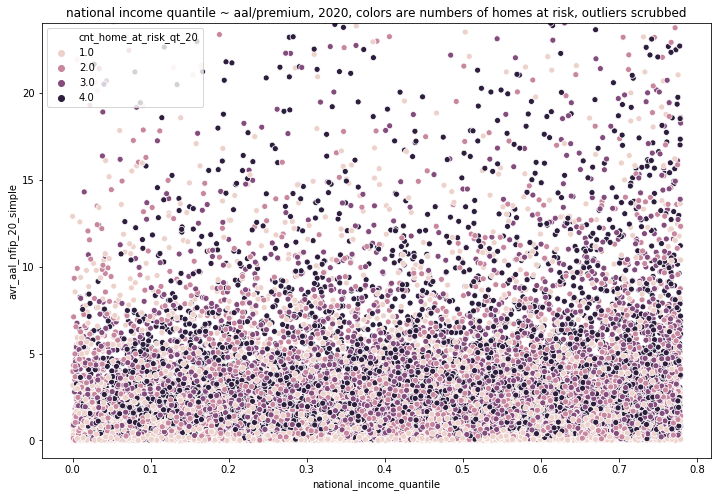

In [62]:
# Plotting original data
plt.figure(figsize=(12, 8))
sns.scatterplot(alldf1.national_income_quantile, alldf1.avr_aal_nfip_20_simple, hue =alldf1.cnt_home_at_risk_qt_20)
plt.ylim((-1,24))
plt.title('national income quantile ~ aal/premium, 2020, colors are numbers of homes at risk, outliers scrubbed');

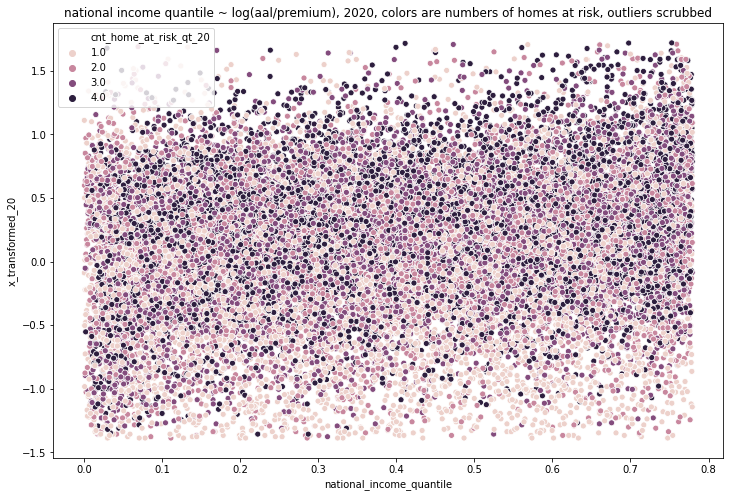

In [63]:
# income ~ log(aal/premium), colorcoding for count of flood prone homes, 2020
plt.figure(figsize=(12, 8))
sns.scatterplot(alldf1[(alldf1.x_transformed_20_outlier ==0)].national_income_quantile, alldf1[(alldf1.x_transformed_20_outlier ==0)].x_transformed_20, hue =alldf1.cnt_home_at_risk_qt_20)
plt.title('national income quantile ~ log(aal/premium), 2020, colors are numbers of homes at risk, outliers scrubbed');

In [64]:
# national_income_quantile~x_transformed_20, for cnt>0 , weighted by cnt
incomequantile20X = alldf1[(pd.isna(alldf1.national_income_quantile) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.properties_with_aal_20_cnt>0)& (alldf1.x_transformed_20_outlier == 0)].national_income_quantile
incomequantile20X = sm.add_constant(incomequantile20X)
mod_wls = sm.WLS(alldf1[(pd.isna(alldf1.national_income_quantile) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.properties_with_aal_20_cnt>0)& (alldf1.x_transformed_20_outlier == 0)].x_transformed_20,
                 incomequantile20X,
                 weights=alldf1[(pd.isna(alldf1.national_income_quantile) == False) & (pd.isna(alldf1.x_transformed_20) == False)& (alldf1.properties_with_aal_20_cnt>0)& (alldf1.x_transformed_20_outlier == 0)].properties_with_aal_20_cnt)
incomequantile20fit = mod_wls.fit()
incomequantile20coef = incomequantile20fit.params[1]
print('national_income_quantile~log(aal/nfip, 2020) , weighted by count of flood prone homes')
print(incomequantile20fit.summary())

national_income_quantile~log(aal/nfip, 2020) , weighted by count of flood prone homes
                            WLS Regression Results                            
Dep. Variable:       x_transformed_20   R-squared:                       0.037
Model:                            WLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     950.4
Date:                Mon, 01 Mar 2021   Prob (F-statistic):          7.55e-205
Time:                        16:10:59   Log-Likelihood:                -38790.
No. Observations:               25004   AIC:                         7.758e+04
Df Residuals:                   25002   BIC:                         7.760e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

R sq is really low. Turning to the binning approach instead.

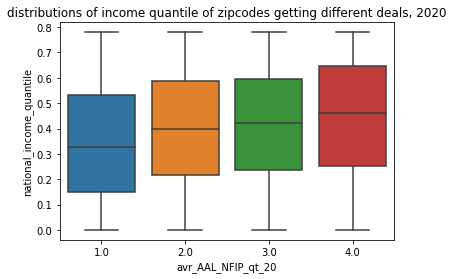

In [65]:
# visual cues
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'national_income_quantile', data= alldf1)
plt.title('distributions of income quantile of zipcodes getting different deals, 2020');

visual cues by quartile of count of properties at risk


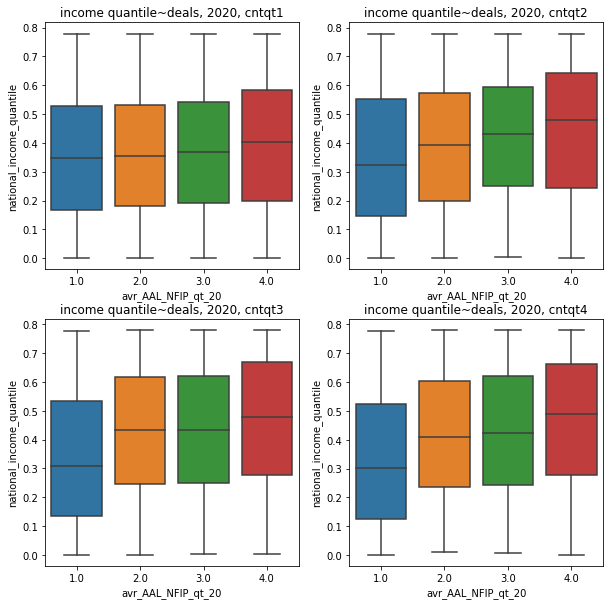

In [66]:
print('visual cues by quartile of count of properties at risk')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'national_income_quantile', data= alldf1[alldf1.cnt_home_at_risk_qt_20==1])
plt.title('income quantile~deals, 2020, cntqt1')

ax = fig.add_subplot(222)
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'national_income_quantile', data= alldf1[alldf1.cnt_home_at_risk_qt_20==2])
plt.title('income quantile~deals, 2020, cntqt2')

ax = fig.add_subplot(223)
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'national_income_quantile', data= alldf1[alldf1.cnt_home_at_risk_qt_20==3])
plt.title('income quantile~deals, 2020, cntqt3')

ax = fig.add_subplot(224)
sns.boxplot(x = 'avr_AAL_NFIP_qt_20', y = 'national_income_quantile', data= alldf1[alldf1.cnt_home_at_risk_qt_20==4])
plt.title('income quantile~deals, 2020, cntqt4');

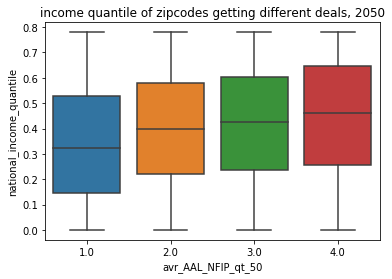

In [67]:
# visual cues 
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'national_income_quantile', data= alldf1)
plt.title('income quantile of zipcodes getting different deals, 2050');

visual cues by quartile of count of properties at risk


Text(0.5, 1.0, 'income quantile~deals, 2050, cntqt4')

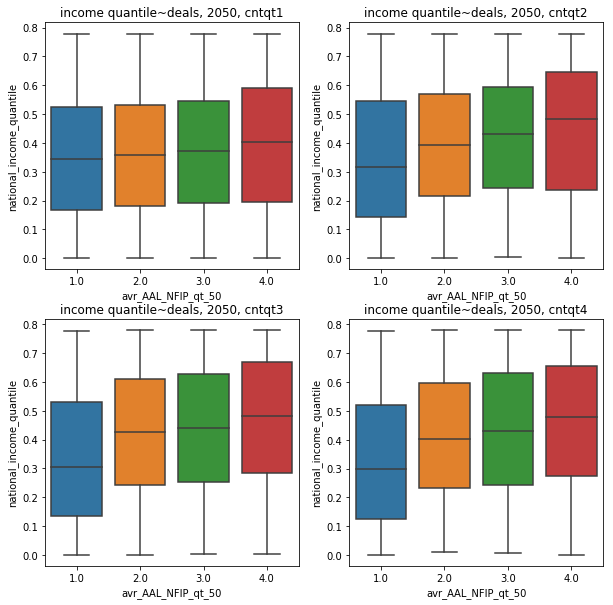

In [68]:
print('visual cues by quartile of count of properties at risk')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'national_income_quantile', data= alldf1[alldf1.cnt_home_at_risk_qt_50==1])
plt.title('income quantile~deals, 2050, cntqt1')

ax = fig.add_subplot(222)
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'national_income_quantile', data= alldf1[alldf1.cnt_home_at_risk_qt_50==2])
plt.title('income quantile~deals, 2050, cntqt2')

ax = fig.add_subplot(223)
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'national_income_quantile', data= alldf1[alldf1.cnt_home_at_risk_qt_50==3])
plt.title('income quantile~deals, 2050, cntqt3')

ax = fig.add_subplot(224)
sns.boxplot(x = 'avr_AAL_NFIP_qt_50', y = 'national_income_quantile', data= alldf1[alldf1.cnt_home_at_risk_qt_50==4])
plt.title('income quantile~deals, 2050, cntqt4')

In [69]:
# putting the data into bins
avr_aal_nfip_income_20 = [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.national_income_quantile) == False)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.national_income_quantile) == False)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.national_income_quantile) == False)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.national_income_quantile) == False)].national_income_quantile]

In [70]:
print('Descriptive stats for the distribution of income quantile for zctas wtih different deals, 2020')
[x.describe() for x in avr_aal_nfip_income_20]

Descriptive stats for the distribution of income quantile for zctas wtih different deals, 2020


[count    6403.000000
 mean        0.346299
 std         0.222261
 min         0.000556
 25%         0.148406
 50%         0.325309
 75%         0.533618
 max         0.779174
 Name: national_income_quantile, dtype: float64,
 count    6464.000000
 mean        0.399989
 std         0.215012
 min         0.000126
 25%         0.217741
 50%         0.399278
 75%         0.585651
 max         0.779174
 Name: national_income_quantile, dtype: float64,
 count    6444.000000
 mean        0.413712
 std         0.213995
 min         0.000430
 25%         0.237527
 50%         0.421423
 75%         0.596524
 max         0.778871
 Name: national_income_quantile, dtype: float64,
 count    6368.000000
 mean        0.443562
 std         0.226346
 min         0.000126
 25%         0.253303
 50%         0.462361
 75%         0.646146
 max         0.779174
 Name: national_income_quantile, dtype: float64]

In [71]:
print('Reject the hypothesis of equal variance?')
stats.levene(avr_aal_nfip_income_20[0],avr_aal_nfip_income_20[1],avr_aal_nfip_income_20[2],avr_aal_nfip_income_20[3])[1]<.05

Reject the hypothesis of equal variance?


True

In [72]:
print('Are the distributions not all the same?')
stats.kruskal(avr_aal_nfip_income_20[0],avr_aal_nfip_income_20[1],avr_aal_nfip_income_20[2],avr_aal_nfip_income_20[3])[1]<.05

Are the distributions not all the same?


True

In [73]:
print('Are the distributions different when it comes to pair-wise comparison?')
sp.posthoc_dunn(avr_aal_nfip_income_20, p_adjust = 'bonferroni')<.05

Are the distributions different when it comes to pair-wise comparison?


,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


In [74]:
print('Comparing income quantiles for zctas getting different deals, with the smallest number of flood prone homes, 2020')
avr_aal_nfip_income_20_qt1= [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.national_income_quantile) == False) & (alldf1.cnt_home_at_risk_qt_20 == 1)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 1)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 1)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 1)].national_income_quantile]

print([x.describe() for x in avr_aal_nfip_income_20_qt1])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_income_20_qt1[0],avr_aal_nfip_income_20_qt1[1],avr_aal_nfip_income_20_qt1[2],avr_aal_nfip_income_20_qt1[3])[1]<.05)
print('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_20_qt1, p_adjust = 'bonferroni')<.05

Comparing income quantiles for zctas getting different deals, with the smallest number of flood prone homes, 2020
[count    2699.000000
mean        0.353022
std         0.214059
min         0.000556
25%         0.166852
50%         0.346044
75%         0.528087
max         0.779174
Name: national_income_quantile, dtype: float64, count    1427.000000
mean        0.361579
std         0.211672
min         0.000126
25%         0.180374
50%         0.355172
75%         0.530141
max         0.778593
Name: national_income_quantile, dtype: float64, count    1162.000000
mean        0.370158
std         0.210675
min         0.000430
25%         0.190138
50%         0.369371
75%         0.540152
max         0.778567
Name: national_income_quantile, dtype: float64, count    1256.000000
mean        0.395818
std         0.224385
min         0.000126
25%         0.196914
50%         0.401307
75%         0.582980
max         0.779174
Name: national_income_quantile, dtype: float64]
Are the distributions

,1,2,3,4
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,True,True,True,False


In [75]:
print('Comparing income for zctas getting different deals, with the second smallest number of flood prone homes, 2020')
avr_aal_nfip_income_20_qt2= [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.national_income_quantile) == False) & (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile]

print([x.describe() for x in avr_aal_nfip_income_20_qt2])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_income_20_qt2[0],avr_aal_nfip_income_20_qt2[1],avr_aal_nfip_income_20_qt2[2],avr_aal_nfip_income_20_qt2[3])[1]<.05)
print('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_20_qt2, p_adjust = 'bonferroni')<.05

Comparing income for zctas getting different deals, with the second smallest number of flood prone homes, 2020
[count    1380.000000
mean        0.351717
std         0.232153
min         0.000784
25%         0.145346
50%         0.323387
75%         0.553696
max         0.776772
Name: national_income_quantile, dtype: float64, count    1683.000000
mean        0.392558
std         0.218533
min         0.002099
25%         0.198409
50%         0.391180
75%         0.572003
max         0.779174
Name: national_income_quantile, dtype: float64, count    1669.000000
mean        0.419984
std         0.210886
min         0.003085
25%         0.249311
50%         0.431689
75%         0.594988
max         0.778871
Name: national_income_quantile, dtype: float64, count    1318.000000
mean        0.442349
std         0.229558
min         0.000329
25%         0.242256
50%         0.479626
75%         0.643399
max         0.779174
Name: national_income_quantile, dtype: float64]
Are the distributions no

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


In [76]:
print('Comparing income for zctas getting different deals,with the second largest number of flood prone homes, 2020')
avr_aal_nfip_income_20_qt3= [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.national_income_quantile) == False) & (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile]

print([x.describe() for x in avr_aal_nfip_income_20_qt3])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_income_20_qt3[0],avr_aal_nfip_income_20_qt3[1],avr_aal_nfip_income_20_qt3[2],avr_aal_nfip_income_20_qt3[3])[1]<.05)
print('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_20_qt3, p_adjust = 'bonferroni')<.05

Comparing income for zctas getting different deals,with the second largest number of flood prone homes, 2020
[count    1380.000000
mean        0.351717
std         0.232153
min         0.000784
25%         0.145346
50%         0.323387
75%         0.553696
max         0.776772
Name: national_income_quantile, dtype: float64, count    1683.000000
mean        0.392558
std         0.218533
min         0.002099
25%         0.198409
50%         0.391180
75%         0.572003
max         0.779174
Name: national_income_quantile, dtype: float64, count    1669.000000
mean        0.419984
std         0.210886
min         0.003085
25%         0.249311
50%         0.431689
75%         0.594988
max         0.778871
Name: national_income_quantile, dtype: float64, count    1318.000000
mean        0.442349
std         0.229558
min         0.000329
25%         0.242256
50%         0.479626
75%         0.643399
max         0.779174
Name: national_income_quantile, dtype: float64]
Are the distributions not 

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


In [77]:
print('Comparing income for zctas getting different deals, with the largest number of flood prone homes, 2020')
avr_aal_nfip_income_20_qt4= [alldf1[(alldf1.avr_AAL_NFIP_qt_20==1) & (pd.isna(alldf1.national_income_quantile) == False) & (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==2) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_20==3) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_20==4) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_20 == 2)].national_income_quantile]

print([x.describe() for x in avr_aal_nfip_income_20_qt4])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_income_20_qt4[0],avr_aal_nfip_income_20_qt4[1],avr_aal_nfip_income_20_qt4[2],avr_aal_nfip_income_20_qt4[3])[1]<.05)
print('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_20_qt4, p_adjust = 'bonferroni')<.05

Comparing income for zctas getting different deals, with the largest number of flood prone homes, 2020
[count    1380.000000
mean        0.351717
std         0.232153
min         0.000784
25%         0.145346
50%         0.323387
75%         0.553696
max         0.776772
Name: national_income_quantile, dtype: float64, count    1683.000000
mean        0.392558
std         0.218533
min         0.002099
25%         0.198409
50%         0.391180
75%         0.572003
max         0.779174
Name: national_income_quantile, dtype: float64, count    1669.000000
mean        0.419984
std         0.210886
min         0.003085
25%         0.249311
50%         0.431689
75%         0.594988
max         0.778871
Name: national_income_quantile, dtype: float64, count    1318.000000
mean        0.442349
std         0.229558
min         0.000329
25%         0.242256
50%         0.479626
75%         0.643399
max         0.779174
Name: national_income_quantile, dtype: float64]
Are the distributions not all th

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


In [78]:
# binning the zipcodes into quartiles according to the deals they'll get in year 2050.
avr_aal_nfip_income_50 = [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.national_income_quantile) == False)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.national_income_quantile) == False)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.national_income_quantile) == False)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.national_income_quantile) == False)].national_income_quantile]

In [79]:
print('Descriptive statistics for the income quantiles of quartiles of zctas getting different deals, 2050')
[x.describe() for x in avr_aal_nfip_income_50]

Descriptive statistics for the income quantiles of quartiles of zctas getting different deals, 2050


[count    6407.000000
 mean        0.343683
 std         0.220680
 min         0.000556
 25%         0.146800
 50%         0.322945
 75%         0.528182
 max         0.779174
 Name: national_income_quantile, dtype: float64,
 count    6478.000000
 mean        0.398847
 std         0.214052
 min         0.000126
 25%         0.219340
 50%         0.398083
 75%         0.580426
 max         0.779174
 Name: national_income_quantile, dtype: float64,
 count    6426.000000
 mean        0.417144
 std         0.215498
 min         0.000430
 25%         0.237527
 50%         0.425367
 75%         0.602113
 max         0.778871
 Name: national_income_quantile, dtype: float64,
 count    6366.000000
 mean        0.443991
 std         0.226440
 min         0.000126
 25%         0.255822
 50%         0.462880
 75%         0.646550
 max         0.779174
 Name: national_income_quantile, dtype: float64]

In [80]:
print('Do the distributions not have equal variance?')
stats.levene(avr_aal_nfip_income_50[0],avr_aal_nfip_income_50[1],avr_aal_nfip_income_50[2],avr_aal_nfip_income_50[3])[1]<.05

Do the distributions not have equal variance?


True

In [81]:
print('Are the distributions not all the same?')
stats.kruskal(avr_aal_nfip_income_50[0],avr_aal_nfip_income_50[1],avr_aal_nfip_income_50[2],avr_aal_nfip_income_50[3])[1]<.05

Are the distributions not all the same?


True

In [82]:
print ('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_50, p_adjust = 'bonferroni')<.05

Are the distributions different in pair-wise comparisons?


,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


In [83]:
print('Compare the income quantiles of zctas getting different deals, just for the zctas having the smallest number of flood prone homes, 2050')
avr_aal_nfip_income_50_qt1= [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.national_income_quantile) == False) & (alldf1.cnt_home_at_risk_qt_50 == 1)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 1)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 1)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 1)].national_income_quantile]

print([x.describe() for x in avr_aal_nfip_income_50_qt1])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_income_50_qt1[0],avr_aal_nfip_income_50_qt1[1],avr_aal_nfip_income_50_qt1[2],avr_aal_nfip_income_50_qt1[3])[1]<.05)

print ('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_50_qt1, p_adjust = 'bonferroni')<.05

Compare the income quantiles of zctas getting different deals, just for the zctas having the smallest number of flood prone homes, 2050
[count    2694.000000
mean        0.351330
std         0.212190
min         0.000556
25%         0.166378
50%         0.343597
75%         0.525795
max         0.779174
Name: national_income_quantile, dtype: float64, count    1413.000000
mean        0.361728
std         0.211056
min         0.000126
25%         0.180507
50%         0.357865
75%         0.530141
max         0.778593
Name: national_income_quantile, dtype: float64, count    1130.000000
mean        0.373876
std         0.210131
min         0.000430
25%         0.192268
50%         0.372279
75%         0.545342
max         0.778567
Name: national_income_quantile, dtype: float64, count    1186.000000
mean        0.396044
std         0.227620
min         0.000126
25%         0.195084
50%         0.402085
75%         0.589100
max         0.779174
Name: national_income_quantile, dtype: float64]

,1,2,3,4
1,False,False,True,True
2,False,False,False,True
3,True,False,False,False
4,True,True,False,False


In [84]:
print('Compare the income quantiles of zctas getting different deals, just for the zctas having the second smallest number of flood prone homes, 2050')
avr_aal_nfip_income_50_qt2= [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.national_income_quantile) == False) & (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile]

print([x.describe() for x in avr_aal_nfip_income_50_qt2])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_income_50_qt2[0],avr_aal_nfip_income_50_qt2[1],avr_aal_nfip_income_50_qt2[2],avr_aal_nfip_income_50_qt2[3])[1]<.05)
print ('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_50_qt2, p_adjust = 'bonferroni')<.05

Compare the income quantiles of zctas getting different deals, just for the zctas having the second smallest number of flood prone homes, 2050
[count    1409.000000
mean        0.346938
std         0.230840
min         0.000784
25%         0.143892
50%         0.315473
75%         0.543834
max         0.776772
Name: national_income_quantile, dtype: float64, count    1774.000000
mean        0.395004
std         0.216641
min         0.002099
25%         0.215563
50%         0.392463
75%         0.570912
max         0.779174
Name: national_income_quantile, dtype: float64, count    1720.000000
mean        0.418977
std         0.212414
min         0.002857
25%         0.243185
50%         0.431613
75%         0.593010
max         0.778871
Name: national_income_quantile, dtype: float64, count    1251.000000
mean        0.444353
std         0.230329
min         0.000329
25%         0.237034
50%         0.482464
75%         0.644967
max         0.779174
Name: national_income_quantile, dtype: f

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


In [85]:
print('Compare the income quantiles of zctas getting different deals, just for the zctas having the second largest number of flood prone homes, 2050')
avr_aal_nfip_income_50_qt3= [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.national_income_quantile) == False) & (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile]

print([x.describe() for x in avr_aal_nfip_income_50_qt3])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_income_50_qt3[0],avr_aal_nfip_income_50_qt3[1],avr_aal_nfip_income_50_qt3[2],avr_aal_nfip_income_50_qt3[3])[1]<.05)
print ('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_50_qt3, p_adjust = 'bonferroni')<.05

Compare the income quantiles of zctas getting different deals, just for the zctas having the second largest number of flood prone homes, 2050
[count    1409.000000
mean        0.346938
std         0.230840
min         0.000784
25%         0.143892
50%         0.315473
75%         0.543834
max         0.776772
Name: national_income_quantile, dtype: float64, count    1774.000000
mean        0.395004
std         0.216641
min         0.002099
25%         0.215563
50%         0.392463
75%         0.570912
max         0.779174
Name: national_income_quantile, dtype: float64, count    1720.000000
mean        0.418977
std         0.212414
min         0.002857
25%         0.243185
50%         0.431613
75%         0.593010
max         0.778871
Name: national_income_quantile, dtype: float64, count    1251.000000
mean        0.444353
std         0.230329
min         0.000329
25%         0.237034
50%         0.482464
75%         0.644967
max         0.779174
Name: national_income_quantile, dtype: fl

,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


In [86]:
print('Compare the income quantiles of zctas getting different deals, just for the zctas having the second largest number of flood prone homes, 2050')
avr_aal_nfip_income_50_qt4= [alldf1[(alldf1.avr_AAL_NFIP_qt_50==1) & (pd.isna(alldf1.national_income_quantile) == False) & (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==2) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                alldf1[(alldf1.avr_AAL_NFIP_qt_50==3) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile,
                                 alldf1[(alldf1.avr_AAL_NFIP_qt_50==4) & (pd.isna(alldf1.national_income_quantile) == False)& (alldf1.cnt_home_at_risk_qt_50 == 2)].national_income_quantile]

# print([x.describe() for x in avr_aal_nfip_income_50_qt4])
print('Are the distributions not all the same?')
print(stats.kruskal(avr_aal_nfip_income_50_qt4[0],avr_aal_nfip_income_50_qt4[1],avr_aal_nfip_income_50_qt4[2],avr_aal_nfip_income_50_qt4[3])[1]<.05)
print ('Are the distributions different in pair-wise comparisons?')
sp.posthoc_dunn(avr_aal_nfip_income_50_qt4, p_adjust = 'bonferroni')<.05

Compare the income quantiles of zctas getting different deals, just for the zctas having the second largest number of flood prone homes, 2050
Are the distributions not all the same?
True
Are the distributions different in pair-wise comparisons?


,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


It seems that the zctas getting the better deals nationwide are, by and large, whiter and have higher income than the zctas getting the worse deals.
## County-wide
Since flood insurance policies are often administerd on the county or city level, we want to know whether the zipcodes getting the best and worst deals in their counties differ from their neighbours in terms of race and income. We excluded zctas that are the only zcta in their counties.<br>

### Race

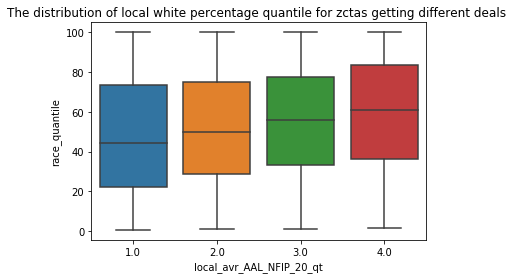

In [87]:
# Look at the white percentage of zctas getting different NFIP/AAL deals on a local level, using the local quantile scores...starting with race.
sns.boxplot(x = 'local_avr_AAL_NFIP_20_qt', y = 'race_quantile', data= alldf1[alldf1.avr_AAL_NFIP_20_array_len>1])
plt.title('The distribution of local white percentage quantile for zctas getting different deals ');

In [88]:
# binning the data for testing
local_avr_aal_nfip_local_race = [alldf1[(len(alldf1.white_pct_array)>1) & (alldf1.local_avr_AAL_NFIP_20_qt==1) & (pd.isna(alldf1.race_quantile) == False)].race_quantile,
                                 alldf1[(len(alldf1.white_pct_array)>1) & (alldf1.local_avr_AAL_NFIP_20_qt==2) & (pd.isna(alldf1.race_quantile) == False)].race_quantile,
                                alldf1[(len(alldf1.white_pct_array)>1) & (alldf1.local_avr_AAL_NFIP_20_qt==3) & (pd.isna(alldf1.race_quantile) == False)].race_quantile,
                                 alldf1[(len(alldf1.white_pct_array)>1) & (alldf1.local_avr_AAL_NFIP_20_qt==4) & (pd.isna(alldf1.race_quantile) == False)].race_quantile]

In [89]:
print ('Descriptive stats for the distributions')
[x.describe() for x in local_avr_aal_nfip_local_race]

Descriptive stats for the distributions


[count    5134.000000
 mean       47.772318
 std        29.169245
 min         0.617284
 25%        22.222222
 50%        44.444444
 75%        73.684211
 max       100.000000
 Name: race_quantile, dtype: float64,
 count    6642.000000
 mean       52.213341
 std        27.755239
 min         1.204819
 25%        28.571429
 50%        50.000000
 75%        75.000000
 max       100.000000
 Name: race_quantile, dtype: float64,
 count    5847.000000
 mean       55.295547
 std        26.916654
 min         1.162791
 25%        33.333333
 50%        55.681818
 75%        77.525510
 max       100.000000
 Name: race_quantile, dtype: float64,
 count    7457.000000
 mean       59.777759
 std        27.899100
 min         1.724138
 25%        36.585366
 50%        62.500000
 75%        83.333333
 max       100.000000
 Name: race_quantile, dtype: float64]

In [90]:
print ('Reject the null hypothesis of equal variance?')
stats.levene(local_avr_aal_nfip_local_race[0],local_avr_aal_nfip_local_race[1],local_avr_aal_nfip_local_race[2],local_avr_aal_nfip_local_race[3])[1]<.05

Reject the null hypothesis of equal variance?


True

In [91]:
print('Are all the distributions not all the same?')
stats.kruskal(local_avr_aal_nfip_local_race[0],local_avr_aal_nfip_local_race[1],local_avr_aal_nfip_local_race[2],local_avr_aal_nfip_local_race[3])[1]<.05

Are all the distributions not all the same?


True

In [92]:
print ('Are the distributions different from each other?')
sp.posthoc_dunn(local_avr_aal_nfip_local_race, p_adjust = 'bonferroni')<.001

Are the distributions different from each other?


,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


It seems that the zctas who are getting the better deals in their counties are also whiter compared to other zctas in the county.
### Income

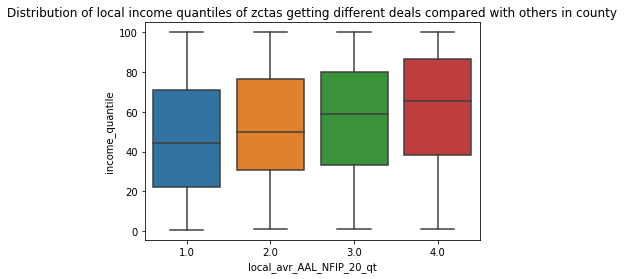

In [93]:
# visual cues
sns.boxplot(x = 'local_avr_AAL_NFIP_20_qt', y = 'income_quantile', data= alldf1[alldf1.avr_AAL_NFIP_20_array_len>1])
plt.title('Distribution of local income quantiles of zctas getting different deals compared with others in county');

In [94]:
# binning data for analysis
local_avr_aal_nfip_local_income = [alldf1[(len(alldf1.income_array)>1) & (alldf1.local_avr_AAL_NFIP_20_qt==1) & (pd.isna(alldf1.income_quantile) == False)].income_quantile,
                                 alldf1[(len(alldf1.income_array)>1) & (alldf1.local_avr_AAL_NFIP_20_qt==2) & (pd.isna(alldf1.income_quantile) == False)].income_quantile,
                                alldf1[(len(alldf1.income_array)>1) & (alldf1.local_avr_AAL_NFIP_20_qt==3) & (pd.isna(alldf1.income_quantile) == False)].income_quantile,
                                 alldf1[(len(alldf1.income_array)>1) & (alldf1.local_avr_AAL_NFIP_20_qt==4) & (pd.isna(alldf1.income_quantile) == False)].income_quantile]

In [95]:
print('Descriptive stats of the distributions')
[x.describe() for x in local_avr_aal_nfip_local_income]

Descriptive stats of the distributions


[count    4914.000000
 mean       47.396016
 std        28.755699
 min         0.621118
 25%        22.222222
 50%        44.444444
 75%        71.148890
 max       100.000000
 Name: income_quantile, dtype: float64,
 count    6468.000000
 mean       53.794194
 std        27.884721
 min         1.000000
 25%        30.729984
 50%        50.000000
 75%        76.519608
 max       100.000000
 Name: income_quantile, dtype: float64,
 count    5733.000000
 mean       57.320269
 std        27.494921
 min         1.204819
 25%        33.333333
 50%        58.823529
 75%        80.000000
 max       100.000000
 Name: income_quantile, dtype: float64,
 count    7250.000000
 mean       62.466827
 std        28.499862
 min         1.234568
 25%        40.000000
 50%        66.666667
 75%        87.500000
 max       100.000000
 Name: income_quantile, dtype: float64]

In [96]:
print ('Reject the null hypothesis of equal variance?')
stats.levene(local_avr_aal_nfip_local_income[0],local_avr_aal_nfip_local_income[1],local_avr_aal_nfip_local_income[2],local_avr_aal_nfip_local_income[3])[1]<.05

Reject the null hypothesis of equal variance?


True

In [97]:
print('Are all the distributions not all the same?')
stats.kruskal(local_avr_aal_nfip_local_income[0],local_avr_aal_nfip_local_income[1],local_avr_aal_nfip_local_income[2],local_avr_aal_nfip_local_income[3])[1]<.05

Are all the distributions not all the same?


True

In [98]:
print ('Are the distributions different from each other?')
sp.posthoc_dunn(local_avr_aal_nfip_local_income, p_adjust = 'bonferroni')<.05

Are the distributions different from each other?


,1,2,3,4
1,False,True,True,True
2,True,False,True,True
3,True,True,False,True
4,True,True,True,False


It seems that the zctas who are getting the better deals in their counties have higher income compared to other zctas in the county.